In [1]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler


#Custome graph format style sheet
plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = True
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.eps'
if not 'location' in locals():
    #save location.  First one is for running on home PC, second for running on the work laptop.  May need to make a global change
    location = 'E:\\Documents\\Dan\\Code\\FigsAndPlots\\FigsAndPlotsDocument\\Figures\\'
    #location = 'C:\\Users\\dhendrickson\\Documents\\github\\FigsAndPlots\\FigsAndPlotsDocument\\Figures\\'



In [2]:
# Task Specific includes:

#import scipy.special as sp
import math
import matplotlib.animation as animation
import time
from numpy import inf
# Choose which EFIT_Class to use:
# import EFIT_Class as EFIT
import EFIT_Class_StressLargerVelocity as EFIT
# import EFIT_Class_OriginalEqualGrid as EFIT
# import EFIT_Class_Parallel_EqualGrid as EFIT
# import EFIT_Class_VelocityLargerStress as EFIT

In [3]:
# set Constants:
PoissonRatio = 0.3
YoungModulus = 20 * (10**9)
mu = 80 * (10**9)         #First Lame Parameter
lmbda = 2 * mu * PoissonRatio / (1 - 2 * PoissonRatio)     #second Lame Parameter
rho = 7800       #density

#Calculate speed of longitudinal and transverse waves
cl = np.sqrt((lmbda + 2* mu)/rho)
ct = np.sqrt(mu/rho)

print(cl,ct)

#Choose ferquency to be used for excitment
frequency = 40000

#calculate wave length
omegal = cl / frequency
omegat = ct / frequency

# about 1foot (0.3m) of just the web of 175lbs rail 
BeamLength = 0.3
BeamHeight = 0.0762
BeamWidth = 0.0381

5991.446895152781 3202.563076101743


In [4]:
#Run for 6 Cycles:
runtime = 4.0 / frequency 

#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
ts = 1 / frequency / 20    #time step
gs = min(omegal, omegat) / 10    #grid step

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time STeps

gl = int(math.ceil(BeamLength / gs)) *2        #number of grid points
gh = int(math.ceil(BeamHeight / gs)) *2
gw = int(math.ceil(BeamWidth / gs)) *2


In [5]:
#Initialize EFIT Model
Rail = EFIT.EFIT(gl, gh, gw, ts, gs)

#Set Material Properties consitant througout
Rail.Gp[0,:,:,:] = rho  #constant Density
Rail.Gp[1,:,:,:] = lmbda #Constant first Lamee parameter 
Rail.Gp[2,:,:,:] = mu  #constant second Lamee parameter


In [6]:
#Run main function for time:
CenterXResults = []
CenterYResults = []
CenterZResults = []

t=0
TempZ=Rail.VelocityCut(2)
CenterZResults.append((TempZ,t))
np.savetxt(str(t)+'.csv', TempZ, delimiter=",")

for i in range(Tsteps - 1):
    t = (i+1) * ts
   
    #update Velocity:
    for x in range(gl):
        for y in range(gh):
            for z in range(gw):
                Rail.UpdateVelocity(x,y,z)

    #if i == 2: Rail.ForcingFunctionImpulse(10)
    if i>=2 and i<=20:
        Rail.ForcingFunctionWave(t, frequency, 100)
    #else:
    #    Rail.ForcingFunctionWave(t, frequency, 0)
    
    #Update Stresses at next half step:
    for x in range(gl):
        for y in range(gh):
            for z in range(gw):
                Rail.UpdateStresses(x,y,z)

    print(str(i+1) + ' of ' + str(Tsteps-1) +' time steps. time is: '+ str(t))
    TempZ=Rail.VelocityCut(2)
    CenterZResults.append((TempZ,t))

    # Store results mid process for latter animating
    if i < 10 or i % 10 == 1:
    

        np.savetxt(str(i)+'V.csv', TempZ, delimiter=",")

    #TempZ=Rail.StressCut(2,1,1)
    #np.savetxt(str(i)+'S11.csv', TempZ, delimiter=",")
    #TempZ=Rail.StressCut(2,1,0)
        #np.savetxt(str(i)+'S10.csv', TempZ, delimiter=",")
        #TempZ=Rail.StressCut(2,1,2)
        #np.savetxt(str(i)+'S12.csv', TempZ, delimiter=",")
        #TempZ=Rail.StressCut(2,0,0)
        #np.savetxt(str(i)+'S00.csv', TempZ, delimiter=",")
        #TempZ=Rail.StressCut(2,0,2)
        #np.savetxt(str(i)+'S02.csv', TempZ, delimiter=",")
        #TempZ=Rail.StressCut(2,2,2)
        #np.savetxt(str(i)+'S22.csv', TempZ, delimiter=",")


1 of 80 time steps. time is: 1.25e-06
2 of 80 time steps. time is: 2.5e-06
3 of 80 time steps. time is: 3.7500000000000005e-06
4 of 80 time steps. time is: 5e-06
5 of 80 time steps. time is: 6.25e-06
6 of 80 time steps. time is: 7.500000000000001e-06
7 of 80 time steps. time is: 8.750000000000001e-06
8 of 80 time steps. time is: 1e-05
9 of 80 time steps. time is: 1.125e-05
10 of 80 time steps. time is: 1.25e-05
11 of 80 time steps. time is: 1.375e-05
12 of 80 time steps. time is: 1.5000000000000002e-05
13 of 80 time steps. time is: 1.6250000000000002e-05
14 of 80 time steps. time is: 1.7500000000000002e-05
15 of 80 time steps. time is: 1.8750000000000002e-05
16 of 80 time steps. time is: 2e-05
17 of 80 time steps. time is: 2.125e-05
18 of 80 time steps. time is: 2.25e-05
19 of 80 time steps. time is: 2.375e-05
20 of 80 time steps. time is: 2.5e-05
21 of 80 time steps. time is: 2.625e-05
22 of 80 time steps. time is: 2.75e-05
23 of 80 time steps. time is: 2.875e-05
24 of 80 time steps. 

e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:128: RuntimeWarning: overflow encountered in float_scalars
  (Lame1*(self.Gv[0,x,y,z]-self.Gv[0,x-1,y,z]+self.Gv[2,x,y,z]-self.Gv[2,x,y,z-1])))
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:153: RuntimeWarning: overflow encountered in float_scalars
  (Lame1*(self.Gv[0,x,y,z]-self.Gv[0,x-1,y,z]+self.Gv[1,x,y,z]-self.Gv[1,x,y-1,z])))


50 of 80 time steps. time is: 6.25e-05


e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:116: RuntimeWarning: overflow encountered in float_scalars
  Lame1*(self.Gv[1,x,y,z]-self.Gv[1,x,y-1,z])
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:141: RuntimeWarning: overflow encountered in float_scalars
  Lame1*(self.Gv[0,x,y,z]-self.Gv[0,x-1,y,z])


51 of 80 time steps. time is: 6.375e-05


e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:110: RuntimeWarning: overflow encountered in float_scalars
  Lame1*(self.Gv[2,x,y,z]-self.Gv[2,x,y,z-1])
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:122: RuntimeWarning: overflow encountered in float_scalars
  Lame1*(self.Gv[1,x,y,z]-self.Gv[1,x,y-1,z]+self.Gv[2,x,y,z]-self.Gv[2,x,y,z-1])
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:147: RuntimeWarning: overflow encountered in float_scalars
  Lame1*(self.Gv[0,x,y,z]-self.Gv[0,x-1,y,z]+self.Gv[2,x,y,z]-self.Gv[2,x,y,z-1])


52 of 80 time steps. time is: 6.500000000000001e-05
53 of 80 time steps. time is: 6.625000000000001e-05


e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:166: RuntimeWarning: overflow encountered in float_scalars
  Lame1*(self.Gv[0,x,y,z]-self.Gv[0,x-1,y,z])
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:172: RuntimeWarning: overflow encountered in float_scalars
  Lame1*(self.Gv[0,x,y,z]-self.Gv[0,x-1,y,z]+self.Gv[1,x,y,z]-self.Gv[1,x,y-1,z])


54 of 80 time steps. time is: 6.75e-05


e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:106: RuntimeWarning: invalid value encountered in float_scalars
  Ds[0,0] = ((1.0/self.ds) * ((Lame1+2*Lame2)*(self.Gv[0,x,y,z]-self.Gv[0,x-1,y,z])))
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:128: RuntimeWarning: invalid value encountered in float_scalars
  (Lame1*(self.Gv[0,x,y,z]-self.Gv[0,x-1,y,z]+self.Gv[2,x,y,z]-self.Gv[2,x,y,z-1])))
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:153: RuntimeWarning: invalid value encountered in float_scalars
  (Lame1*(self.Gv[0,x,y,z]-self.Gv[0,x-1,y,z]+self.Gv[1,x,y,z]-self.Gv[1,x,y-1,z])))


55 of 80 time steps. time is: 6.875e-05


e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:279: RuntimeWarning: invalid value encountered in float_scalars
  (self.Gs[0,0,x+1,y,z] - self.Gs[0,0,x,y,z] + self.Gs[0,1,x,y,z] - self.Gs[0,1,x,y-1,z] + self.Gs[0,2,x,y,z] -self.Gs[0,2,x,y,z-1])
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:115: RuntimeWarning: invalid value encountered in float_scalars
  ((Lame1+2*Lame2)*(self.Gv[0,x,y,z]-self.Gv[0,x-1,y,z]) +
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:116: RuntimeWarning: invalid value encountered in float_scalars
  Lame1*(self.Gv[1,x,y,z]-self.Gv[1,x,y-1,z])
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:140: RuntimeWarning: invalid value encountered in float_scalars
  ((Lame1+2*Lame2)*(self.Gv[1,x,y,z]-self.Gv[1,x,y-1,z]) +
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:141: RuntimeWarning: invalid value encountered in float_scalars
  Lame1*(self.Gv[0,x,y,z]-self.Gv[0,x-1,y,z])
e:\Documents

56 of 80 time steps. time is: 7.000000000000001e-05


e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:291: RuntimeWarning: invalid value encountered in float_scalars
  (self.Gs[0,1,x,y,z] - self.Gs[0,1,x-1,y,z] + self.Gs[1,1,x,y+1,z] - self.Gs[1,1,x,y,z] + self.Gs[1,2,x,y,z] -self.Gs[1,2,x,y,z-1])


57 of 80 time steps. time is: 7.125000000000001e-05
58 of 80 time steps. time is: 7.25e-05
59 of 80 time steps. time is: 7.375e-05


e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:109: RuntimeWarning: invalid value encountered in float_scalars
  ((Lame1+2*Lame2)*(self.Gv[0,x,y,z]-self.Gv[0,x-1,y,z]) +
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:166: RuntimeWarning: invalid value encountered in float_scalars
  Lame1*(self.Gv[0,x,y,z]-self.Gv[0,x-1,y,z])


60 of 80 time steps. time is: 7.500000000000001e-05


e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:121: RuntimeWarning: invalid value encountered in float_scalars
  ((Lame1+2*Lame2)*(self.Gv[0,x,y,z]-self.Gv[0,x-1,y,z]) +
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:122: RuntimeWarning: invalid value encountered in float_scalars
  Lame1*(self.Gv[1,x,y,z]-self.Gv[1,x,y-1,z]+self.Gv[2,x,y,z]-self.Gv[2,x,y,z-1])
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:146: RuntimeWarning: invalid value encountered in float_scalars
  ((Lame1+2*Lame2)*(self.Gv[1,x,y,z]-self.Gv[1,x,y-1,z]) +
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:147: RuntimeWarning: invalid value encountered in float_scalars
  Lame1*(self.Gv[0,x,y,z]-self.Gv[0,x-1,y,z]+self.Gv[2,x,y,z]-self.Gv[2,x,y,z-1])
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:172: RuntimeWarning: invalid value encountered in float_scalars
  Lame1*(self.Gv[0,x,y,z]-self.Gv[0,x-1,y,z]+self.Gv[1,x,y,z]-self.Gv[1,x

61 of 80 time steps. time is: 7.625000000000001e-05


e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:303: RuntimeWarning: invalid value encountered in float_scalars
  (self.Gs[0,2,x,y,z] - self.Gs[0,2,x-1,y,z] + self.Gs[1,2,x,y,z] - self.Gs[1,2,x,y-1,z] + self.Gs[2,2,x,y,z+1] -self.Gs[2,2,x,y,z])


62 of 80 time steps. time is: 7.75e-05


e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:322: RuntimeWarning: invalid value encountered in add
  self.Gs[:,:,x,y,z] += delS[:,:] * self.ts


63 of 80 time steps. time is: 7.875e-05
64 of 80 time steps. time is: 8e-05
65 of 80 time steps. time is: 8.125000000000001e-05
66 of 80 time steps. time is: 8.250000000000001e-05


e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:146: RuntimeWarning: invalid value encountered in double_scalars
  ((Lame1+2*Lame2)*(self.Gv[1,x,y,z]-self.Gv[1,x,y-1,z]) +


67 of 80 time steps. time is: 8.375e-05
68 of 80 time steps. time is: 8.5e-05
69 of 80 time steps. time is: 8.625000000000001e-05
70 of 80 time steps. time is: 8.750000000000001e-05
71 of 80 time steps. time is: 8.875e-05
72 of 80 time steps. time is: 9e-05


e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_StressLargerVelocity.py:121: RuntimeWarning: invalid value encountered in double_scalars
  ((Lame1+2*Lame2)*(self.Gv[0,x,y,z]-self.Gv[0,x-1,y,z]) +


73 of 80 time steps. time is: 9.125000000000001e-05
74 of 80 time steps. time is: 9.250000000000001e-05
75 of 80 time steps. time is: 9.375e-05
76 of 80 time steps. time is: 9.5e-05
77 of 80 time steps. time is: 9.625000000000001e-05
78 of 80 time steps. time is: 9.750000000000001e-05
79 of 80 time steps. time is: 9.875e-05
80 of 80 time steps. time is: 0.0001


C:\Users\Hendrickson\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
MovieWriter ffmpeg unavailable; using Pillow instead.


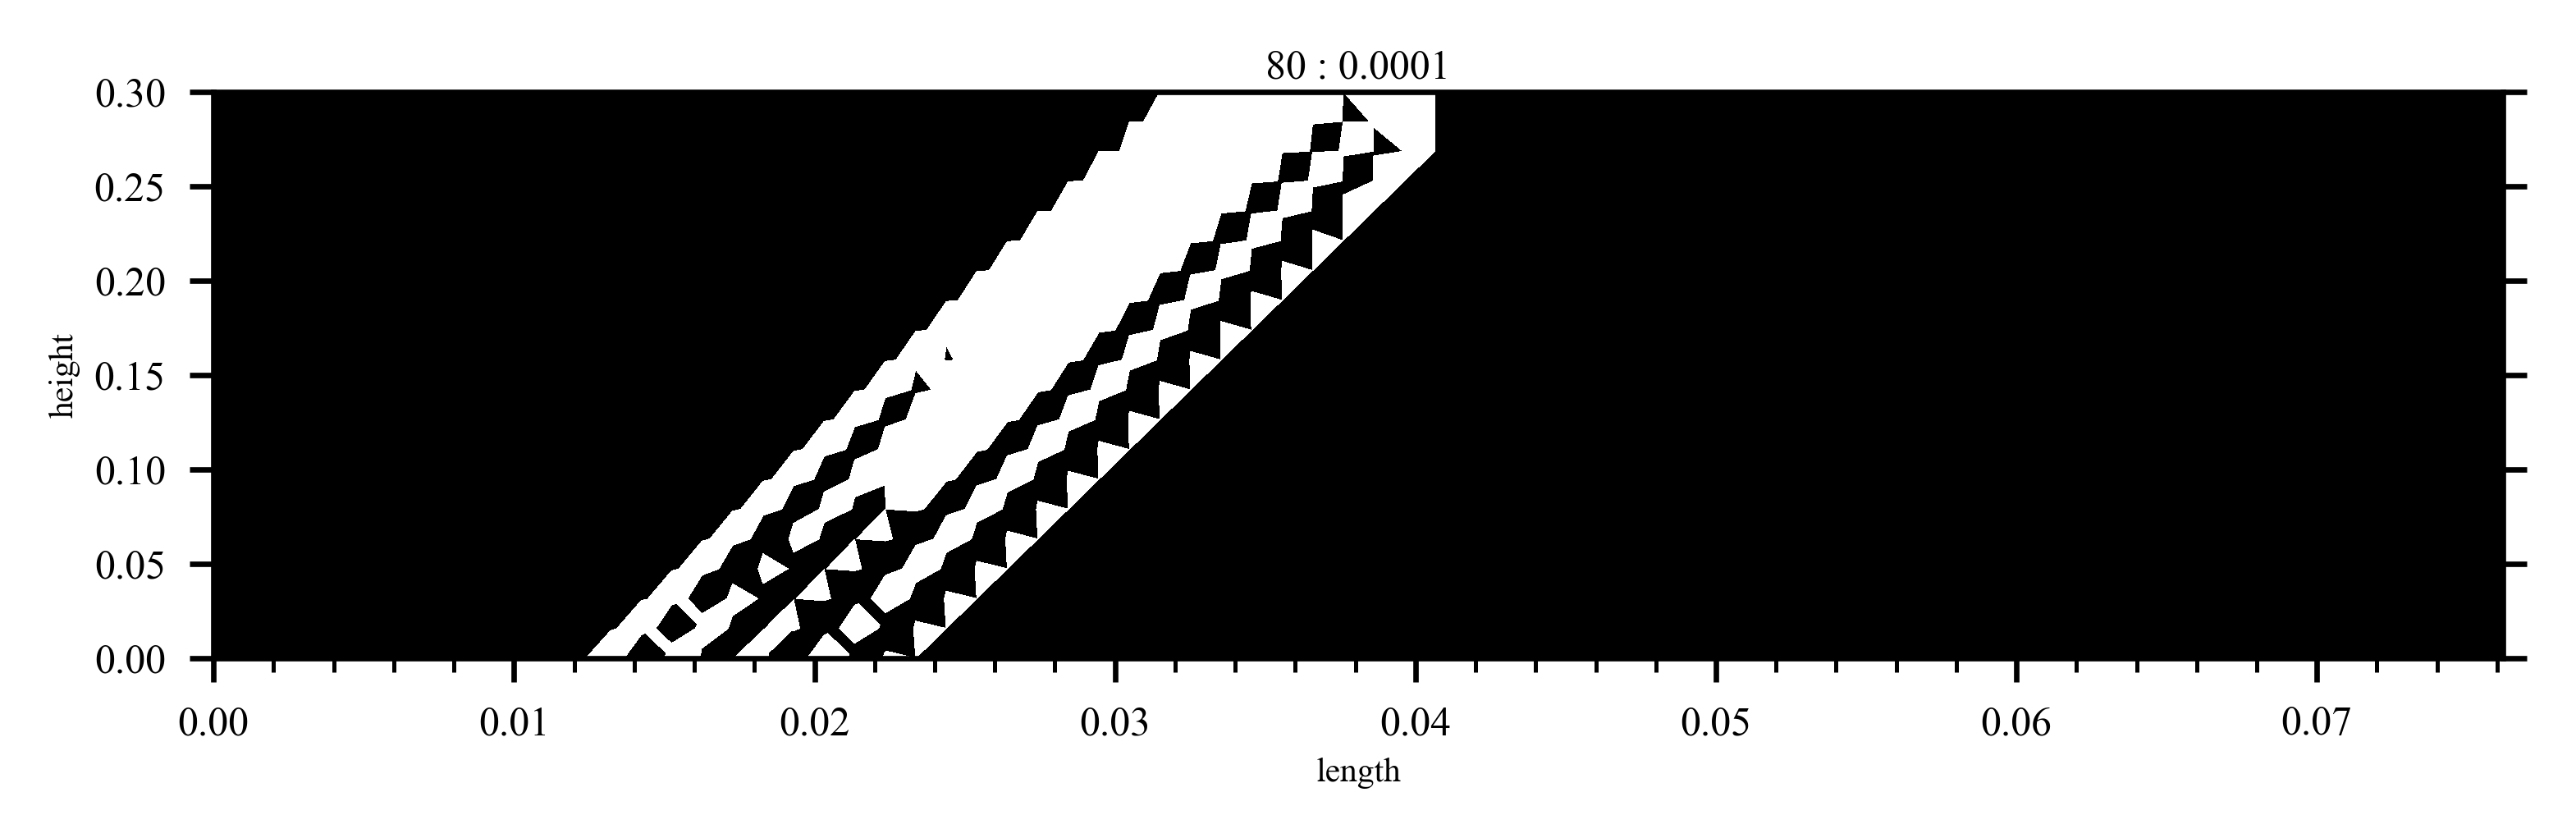

In [7]:
y = np.linspace(0, BeamLength, np.shape(CenterZResults[0][0])[1])
x = np.linspace(0, BeamHeight, np.shape(CenterZResults[0][0])[0])
x,y = np.meshgrid(x,y)

fig = plt.figure(figsize=(6.0,BeamHeight/BeamLength*6.0))
ax = plt.axes(xlim=(0, BeamHeight), ylim=(0, BeamLength))  
plt.ylabel(r'height')
plt.xlabel(r'length')

# animation function
def animate(i): 
    z = np.matrix(CenterZResults[i][0][:,:]).T
    plt.title(str(i) + ' : ' + str(CenterZResults[i][1]))
    cont = plt.contourf(x, y, z, levels=5, cmap='gray',vmin=-100, vmax=100)
    time.sleep(1)
    return cont  

anim = animation.FuncAnimation(fig, animate, frames=np.shape(CenterZResults)[0])

anim.save('animationZ.gif')

In [8]:
x,y,z, gl, gh, gw, np.shape(Rail.Gp)

(array([[0.      , 0.001016, 0.002032, ..., 0.074168, 0.075184, 0.0762  ],
        [0.      , 0.001016, 0.002032, ..., 0.074168, 0.075184, 0.0762  ],
        [0.      , 0.001016, 0.002032, ..., 0.074168, 0.075184, 0.0762  ],
        ...,
        [0.      , 0.001016, 0.002032, ..., 0.074168, 0.075184, 0.0762  ],
        [0.      , 0.001016, 0.002032, ..., 0.074168, 0.075184, 0.0762  ],
        [0.      , 0.001016, 0.002032, ..., 0.074168, 0.075184, 0.0762  ]]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.01578947, 0.01578947, 0.01578947, ..., 0.01578947, 0.01578947,
         0.01578947],
        [0.03157895, 0.03157895, 0.03157895, ..., 0.03157895, 0.03157895,
         0.03157895],
        ...,
        [0.26842105, 0.26842105, 0.26842105, ..., 0.26842105, 0.26842105,
         0.26842105],
        [0.28421053, 0.28421053, 0.28421053, ..., 0.28421053, 0.28421053,
         0.28421053],
        [0.3       , 0.3       , 0.3      